In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
# import calendar

path_to_data = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/analytics_practice/project_ecommerce/data/'

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

– Начнём с импорта и изучения данных

In [3]:
customers = pd.read_csv(path_to_data + 'olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
orders = pd.read_csv(path_to_data + 'olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', \
                                                                             'order_approved_at', \
                                                                             'order_delivered_carrier_date', \
                                                                             'order_delivered_customer_date', \
                                                                             'order_estimated_delivery_date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [5]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [40]:
orders.order_purchase_timestamp.isna().sum()

0

Посмотрев на то, какие бывают статусы у заказов, принимаем решение, что считать покупкой. Так как в данном случае отсутствует возможность пояснить у заказчика, какие именно покупки его интересуют, что я бы предпочёл сделать, я оттолкнулся от наличия у всех заказов отметки со временем покупки, и принял решение учитывать все заказы. Исходя из целей анализа, в данном случае – выявления клиентов без повторных покупок, я предполагаю, что размещение заказа, как первый шаг воронки, соответствует логике задания. Поэтому, принимаем заказы с любым статусом, включая отменённые, так как отмена теоретически может происходить уже после оплаты / покупки.

In [6]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Проверив количество ID двух разных типов, для идентификации отдельных пользователей нам нужно будет использовать customer_unique_id, т к исходя из описания данных каждый из них ассоциирован только с одним пользователем. Чтобы рассчитать количество заказов у каждого пользователя, объединим датафреймы используя позаказный идентификатор пользователя, и аггрегировав количество заказов по уникальным идентификаторам пользоваля. После чего сосчитаем количество пользователей c одним заказом.

In [7]:
customer_order_count = orders.merge(customers, on='customer_id', how='left'). \
    groupby('customer_unique_id'). \
    agg(order_count=('order_id', 'count'))

num_singles = customer_order_count.query('order_count == 1').count()
print(num_singles.order_count)

93099


Ответ: Сопоставив уникальные ID пользователя с их заказами, используя позаказный ID пользователей, получаем что у нас 93 099 пользователя, которые совершили покупку по 1 разу

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

– Не доставленным заказом будем считать подтверждённый заказ, у которого не указана дата доставки 

In [48]:
# Создадим столбец для месяца, приведя дату покупки для заказа к первому числу соответствующего месяца
orders['purchase_month'] = orders.order_purchase_timestamp.to_numpy().astype('datetime64[M]')
# Отберём не доставленные заказы – подтверждённые заказы, у которых не указана дата доставки 
non_delivered_orders = orders.loc[orders.order_delivered_customer_date.isna() & orders.order_approved_at.notna()]
# Создадим pivot-таблицу, в которой будет посчитано количество заказов с различным статусом по месяцам
orders_status_pivot = pd.pivot_table(non_delivered_orders, values='order_id', index='purchase_month', columns='order_status', fill_value=0, aggfunc='count')
# Наконец, посчитаем среднее значение для каждого из встречающихся статусов, исключив не интересующий в данном случае статус "delivered"
non_delivered_mean = orders_status_pivot.drop(columns=['delivered']).mean().reset_index().round(2)
non_delivered_mean.columns = ['order_status', 'mean']

non_delivered_mean

,order_status,mean
0,approved,0.09
1,canceled,20.78
2,invoiced,13.65
3,processing,13.09
4,shipped,48.13
5,unavailable,26.48


В таблице выше мы имеем среднемесячное количество заказов, отнесённых к определённому статусу в течение месяца. Особый интерес вызывает наиболее распространённый статус – shipped, относящийся к заказам, которые отгружены со склада. Однако, несмотря на то, что мы анализируем данные за длительный период, каждый месяц в этом статусе остаётся в среднем 46 заказов, хотя для успешной реализации, после отгрузки эти заказы должны переходить в статус "доставлен". Для подтверждения того, что этот статус нужно относить к причинам не доставки, проведём дополнительный анализ.

In [49]:
# Чтобы взвесить, насколько долго в среднем товар доставляться, оценим средний срок доставки

mean_delivedy_days = (orders['order_delivered_customer_date'] 
                      - orders['order_purchase_timestamp']) \
                      / np.timedelta64(1, 'D')
mean_delivedy_days.mean().round(1)

12.6

In [50]:
# Проверим дату самого позднего заказ, до сих пор находящегося в статусе "отправлен"
latest_shipped_tz = orders.loc[orders.order_status == 'shipped'].order_purchase_timestamp.max()
latest_shipped_tz

Timestamp('2018-09-03 09:06:57')

In [51]:
# Рассчитаем, сколько дней прошло с даты этого заказа и последнего заказа базе
orders.order_purchase_timestamp.max() - latest_shipped_tz 

Timedelta('44 days 08:23:21')

In [52]:
# Дополнительно, уточним, есть ли "отправленные" заказы, которые не были переданы оператору доставки
orders.loc[(orders.order_status == 'shipped') & (orders.order_delivered_carrier_date.isna())].order_id.count()

0

Как видим, самый поздний из заказов, находящихся в статусе "отправлен", был размещён на месяц раньше, чем средний срок доставки заказа, соответственно, тот факт что они всё ещё находятся в пути – не является нормой. Кроме того, мы видим что все данные заказы действительно были переданы доставщикам, о чём есть соответствующая запись.

In [54]:
# Аналогичную проверку проведём для заказов в статусе 'approved'

latest_approved_tz = orders.loc[orders.order_status == 'approved'].order_purchase_timestamp.max()
print('Latest approved at: ' + str(latest_approved_tz))
print(orders.order_purchase_timestamp.max() - latest_approved_tz)

Latest approved at: 2017-04-25 01:25:34
540 days 16:04:44


Как видим, данные заказы были размещены длительное время назад, однако так как среднемесячное количество заказов в этом статусе намного менее 1-го в месяц, я принял решение не учитывать их в ответе.

In [56]:
non_delivered_mean.drop(non_delivered_mean[non_delivered_mean['mean'] <= 1.0].index, inplace=True)

In [57]:
# Аналогичную проверку проведём для заказов в статусе 'invoiced' и 'processing'

latest_invoiced_tz = orders.loc[orders.order_status == 'invoiced'].order_purchase_timestamp.max()
print('Latest invoiced at: ' + str(latest_invoiced_tz))
print(orders.order_purchase_timestamp.max() - latest_invoiced_tz)

latest_processing_tz = orders.loc[orders.order_status == 'processing'].order_purchase_timestamp.max()
print('Latest processing at: ' + str(latest_processing_tz))
print(orders.order_purchase_timestamp.max() - latest_processing_tz)

Latest invoiced at: 2018-08-14 18:45:08
63 days 22:45:10
Latest processing at: 2018-07-23 18:03:03
85 days 23:27:15


In [58]:
print(non_delivered_mean.sort_values('mean', ascending=False))

  order_status   mean
4      shipped  48.13
5  unavailable  26.48
1     canceled  20.78
2     invoiced  13.65
3   processing  13.09


Text(0, 0.5, 'Наименование причины')

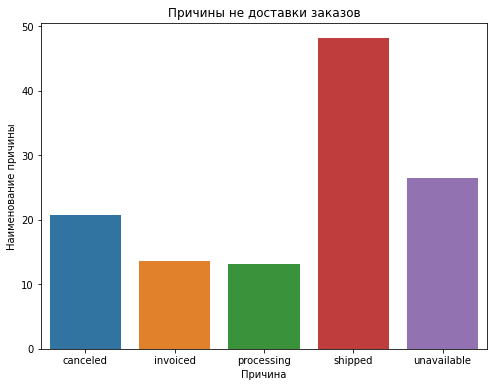

In [59]:
# Визуализируем данные
plt.figure(figsize=(8,6))
sns.barplot(data=non_delivered_mean, y='mean', x='order_status')
plt.title('Причины не доставки заказов')
plt.xlabel('Причина')
plt.ylabel('Наименование причины')

Ответ: 

Причины и количество заказов, не доставленных по ним, представлены ниже:

Отгружен доставшику, но не доставлен – 46.12
Отменён покупателем – 25.79
Недоступен –  25.38
Выставлен счёт – 13.08
Находится в обработке  12.54

Наиболее распространённый статус не доставленного заказа – отправлен (shipped). Так как средний срок доставки по доставленным заказам – 12,6 дней, а самый поздний заказ, статус которого "отправлен" – был отправлен полтора месяца назад, следует обратиться за уточнением к отделу доставки.

Cледующие по распространённости причины – отмена (canceled) и недоступность заказа (unavailable). За которыми следуют нахождение заказа в статусе выставлен инвойс (invoiced) и обработка (processing).

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)


In [72]:
order_items = pd.read_csv(path_to_data + 'olist_order_items_dataset.csv')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Объединим базы товарных позиций и заказов, взяв только столбцы, относящиеся к товарным позициям и дате заказа

In [73]:
items_purchase_dates = order_items[['order_id', 'product_id']]. \
    merge(orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

items_purchase_dates.dtypes

order_id                            object
product_id                          object
order_purchase_timestamp    datetime64[ns]
dtype: object

Приведём дату покупки каждой тованой позиции к дню недели (в виде его порядкового номера).

Для проверки, посмотрим на распределение по дням недели покупок одного из популярных товаров

In [74]:
items_purchase_dates['weekday'] = items_purchase_dates.order_purchase_timestamp.apply(datetime.datetime.weekday)
items_purchase_dates[items_purchase_dates.product_id == '368c6c730842d78016ad823897a372db'].weekday.value_counts()

4    67
1    63
3    58
6    54
2    52
0    50
5    44
Name: weekday, dtype: int64

In [75]:
top_weekdays_by_product = items_purchase_dates. \
    groupby(['product_id', 'weekday']). \
    agg({'order_purchase_timestamp': 'count'}). \
    reset_index(). \
    sort_values(by='order_purchase_timestamp', ascending=False, ignore_index=True). \
    groupby('product_id').head(1). \
    rename(columns={'weekday': 'top_weekday', 
                    'order_purchase_timestamp': 'num_orders'}) \
    .reset_index().drop(columns=['index'])

top_weekdays_by_product.head()

,product_id,top_weekday,num_orders
0,422879e10f46682990de24d770e7f83d,2,93
1,99a4788cb24856965c36a24e339b6058,0,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,3,89
3,53b36df67ebb7c41585e8d54d6772e08,1,76
4,368c6c730842d78016ad823897a372db,4,67


Для удобства чтения переименуем дни недели

In [76]:
def renameWeekday(weekday):
    weekDaysMapping = ("Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс")
    return weekDaysMapping[weekday]
    
top_weekdays_by_product.top_weekday = top_weekdays_by_product.top_weekday.apply(renameWeekday)
top_weekdays_by_product.head()

,product_id,top_weekday,num_orders
0,422879e10f46682990de24d770e7f83d,Ср,93
1,99a4788cb24856965c36a24e339b6058,Пн,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,Чт,89
3,53b36df67ebb7c41585e8d54d6772e08,Вт,76
4,368c6c730842d78016ad823897a372db,Пт,67


Ответ: В датафрейме top_weekdays_by_product приведены самые популярные дни недели в которые каждый товар покупается чаще всего, и количество заказов данного товара, произведённое в этот день недели. 

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

– Хотя на мой взгляд формулировка задания не на 100% прозрачная, исходя из цели предоставить информативные данные для менеджера продукта в отсутствие возможности запроса уточнений, я принял решение рассчитать для каждого месяца метрику по формуле: (количество заказов на 1 пользователя / количество недель в месяце) / количество активных пользователей, совершивших заказы в этот месяц.

Добавим к списку заказов уникальные идентификаторы пользователей, объединив датафреймы

In [77]:
customers_orders = customers[['customer_id', 'customer_unique_id']].merge(orders, on='customer_id')

Сгруппируем по месяцам и уникальным ID покупателей, и посчитаем заказы, чтобы получить количество покупок каждого покупателя за месяц.

In [86]:
orders_weekly_count = customers_orders.groupby(['purchase_month', 'customer_unique_id']). \
                        agg(order_count=('order_id', 'count')).reset_index()
orders_weekly_count

,purchase_month,customer_unique_id,order_count
0,2016-09-01,009b0127b727ab0ba422f6d9604487c7,1
1,2016-09-01,4854e9b3feff728c13ee5fc7d1547e92,1
2,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1
3,2016-09-01,b7d76e111c89f7ebf14761390f0f7d17,1
4,2016-10-01,0032c76b20340da25249092a268ce66c,1
...,...,...,...
98041,2018-09-01,ff22e30958c13ffe219db7d711e8f564,1
98042,2018-10-01,262e1f1e26e92e86375f86840b4ffd63,1
98043,2018-10-01,634420a0ea42302205032ed44ac7fccc,1
98044,2018-10-01,87ab9fec999db8bd5774917de3cdf01c,1


Создадим столбец, в котором разделим количество заказов пользователя за месяц на количество недель в этом месяце

In [89]:
orders_weekly_count['orders_per_week'] = \
    orders_weekly_count.order_count / (orders_weekly_count.purchase_month.dt.daysinmonth / 7)

orders_weekly_count.head()

,purchase_month,customer_unique_id,order_count,orders_per_week
0,2016-09-01,009b0127b727ab0ba422f6d9604487c7,1,0.233333
1,2016-09-01,4854e9b3feff728c13ee5fc7d1547e92,1,0.233333
2,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1,0.233333
3,2016-09-01,b7d76e111c89f7ebf14761390f0f7d17,1,0.233333
4,2016-10-01,0032c76b20340da25249092a268ce66c,1,0.225806


Наконец рассчитаем среднее количество покупок в неделю по клиентам по месяцам. Добавим также проверочный столбец, чтобы убедиться что учтены все заказы. При проверке видим что их количество исходное – 99441

In [93]:
weekly_orders = orders_weekly_count.groupby('purchase_month'). \
                    agg(mean_per_week = ('orders_per_week', 'mean'), 
                        total_orders = ('order_count', 'sum')). \
                    reset_index()
weekly_orders.total_orders.sum(axis=0)

99441

In [94]:
weekly_orders.head()

,purchase_month,mean_per_week,total_orders
0,2016-09-01,0.233333,4
1,2016-10-01,0.227917,324
2,2016-12-01,0.225806,1
3,2017-01-01,0.236137,800
4,2017-02-01,0.253561,1780


Ответ: cреднее количество покупок каждого (активного в этот месяц) пользователя в неделю, рассчитанное для каждого месяца, приведено в столбце mean_per_week датфрейма weekly_orders

## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

В качестве событий, которые которые будем считать как целевые, я выбрал заказы (по дате того события, которое совершается клиентом самостоятельно – покупка). Размер когорты – месяц, а retention буду рассчитывать при помощи повторных заказов тех покупателей, первая покупка которых произошла в определённый месяц. При этом, заказы со статусом "отменён" (canceled) учитываться не будут, так как предполагаем что это те заказы, которые клиент самостоятельно отменил, соответственно, они не должны считаться успешным / целевым событиям. Заказы со статусом "unavailable" я принял решение оставить, так как предполагаю что это заказы, не состоявшиеся не по вине покупателя, и, следственно, их не успешность не должна отражаться на оценке его лояльности. 

Отфильтруем датафрейм по правилам, которые мы приняли выше, оставив только нужные столбцы

In [130]:
customers_orders_narrow = customers_orders.loc[customers_orders.order_status != 'canceled'][['customer_unique_id', 'order_purchase_timestamp', 'purchase_month']]
customers_orders_narrow.order_purchase_timestamp.count()

98816

Определим когорту каждого пользователя по месяцу первой покупки

In [131]:
customer_cohorts = customers_orders_narrow. \
    groupby('customer_unique_id'). \
    agg(cohort_month = ('purchase_month', 'min')). \
    reset_index()
customer_cohorts

,customer_unique_id,cohort_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
95556,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
95557,ffff371b4d645b6ecea244b27531430a,2017-02-01
95558,ffff5962728ec6157033ef9805bacc48,2018-05-01


Добавим при помощи right join все месяцы, в которые пользователи совершали покупки

In [132]:
customer_cohorts = customer_cohorts. \
    merge(customers_orders_narrow[['customer_unique_id', 'purchase_month']], on = 'customer_unique_id', how = 'right')
customer_cohorts.nunique()

customer_unique_id    95560
cohort_month             23
purchase_month           24
dtype: int64

In [133]:
# Проверим что учтены все заказы
customer_cohorts.purchase_month.count()

98816

In [134]:
customer_cohorts.head()

,customer_unique_id,cohort_month,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-01,2018-01-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-01,2018-05-01
3,259dac757896d24d7702b9acbbff3f3c,2018-03-01,2018-03-01
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-01,2018-07-01


Согласно заданию, отфильтруем период с января по декабрь

In [135]:
customer_cohorts = customer_cohorts. \
    loc[(customer_cohorts.cohort_month >= pd.to_datetime('2017-01-01')) & (customer_cohorts.cohort_month <= pd.to_datetime('2017-12-01'))]
customer_cohorts.head()

,customer_unique_id,cohort_month,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01
5,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-09-01
6,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-10-01
8,57b2a98a409812fe9618067b6b8ebe4f,2017-11-01,2017-11-01
12,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-01,2017-11-01


In [ ]:
Определим, индекс каждой покупки внутри когорты: в какой месяц с первой покупки пользователя она была совершена

In [136]:
def get_index(df, col1, col2):

    cohort_year = pd.to_datetime(df[col1]).dt.year
    cohort_month = pd.to_datetime(df[col1]).dt.month
    purchase_year = pd.to_datetime(df[col2]).dt.year
    purchase_month = pd.to_datetime(df[col2]).dt.month
    return (purchase_year - cohort_year) * 12 + purchase_month - cohort_month

customer_cohorts['cohort_index'] = get_index(customer_cohorts, "cohort_month", "purchase_month")

,customer_unique_id,cohort_month,purchase_month,cohort_index
0,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01,0
5,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-09-01,0
6,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-10-01,1
8,57b2a98a409812fe9618067b6b8ebe4f,2017-11-01,2017-11-01,0
12,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-01,2017-11-01,0
...,...,...,...,...
98805,277490f0d435b602fe4475d4b89e9181,2017-05-01,2017-05-01,0
98808,e7f8760e2bbd2f1986bebd99596c088e,2017-03-01,2017-03-01,0
98810,4b5820135d360a45552b5163835b1d89,2017-12-01,2017-12-01,0
98814,73c2643a0a458b49f58cea58833b192e,2017-11-01,2017-11-01,0


In [137]:
customer_cohorts.head()

,customer_unique_id,cohort_month,purchase_month,cohort_index
0,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01,0
5,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-09-01,0
6,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-10-01,1
8,57b2a98a409812fe9618067b6b8ebe4f,2017-11-01,2017-11-01,0
12,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-01,2017-11-01,0


Наконец, сгруппируем строки по наименованию когорты и индексу (месяцу) внутри когорты, а также рассчитаем retention rate для каждого мецсяца 

In [138]:
cohorts = customer_cohorts.groupby(['cohort_month', 'cohort_index']).agg(customers=('customer_unique_id', 'nunique'))
cohorts['retention_rate'] = cohorts.customers / cohorts.groupby('cohort_month').customers.max() * 100
cohorts

customers  retention_rate
cohort_month cohort_index                           
2017-01-01   0                   762      100.000000
             1                     3        0.393701
             2                     2        0.262467
             3                     1        0.131234
             4                     3        0.393701
...                              ...             ...
2017-12-01   4                    15        0.273773
             5                    11        0.200767
             6                     9        0.164264
             7                     3        0.054755
             8                    12        0.219018

[171 rows x 2 columns]

Согласно заданию, отфильтруем и отсортируем данные, чтобы получить retention по когортам только на третий месяц. Также, визуализируем retention при помощи графика.

In [141]:
df = cohorts.reset_index()
third_month = df.loc[df.cohort_index == 3].sort_values('retention_rate', ascending=False).reset_index(drop=True)
third_month['cohort_month'] = pd.to_datetime(third_month['cohort_month']).dt.month
third_month

,cohort_month,cohort_index,customers,retention_rate
0,6,3,13,0.415867
1,5,3,14,0.392047
2,3,3,10,0.384172
3,12,3,19,0.346779
4,9,3,12,0.291829
5,8,3,11,0.264296
6,7,3,10,0.258532
7,4,3,4,0.171380
8,11,3,12,0.165062
9,1,3,1,0.131234


Text(0, 0.5, 'Retention rate')

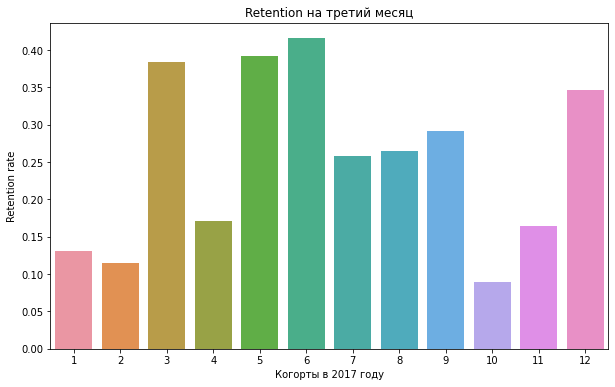

In [143]:
plt.figure(figsize=(10,6))
sns.barplot(data=third_month, x='cohort_month', y='retention_rate')
plt.title('Retention на третий месяц')
plt.xlabel('Когорты в 2017 году')
plt.ylabel('Retention rate')

Ответ: самый высокий retention на 3 месяц с января по декабрь наблюдался в июньской когорте.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 